# CDS-RL Demos
A place to experiment with RL techniques on various systems that are well-understood by CDS

Note: set up a conda environment according to setup_instructions.txt 

In [ ]:
import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'


## Sanity check: Spinningup

Setup

In [ ]:
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

In [ ]:
env_fn = lambda : gym.make('LunarLander-v2')
ac_kwargs = dict(hidden_sizes=[64,64], activation=tf.nn.relu)
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment)

Run each exp (saves outputs automatically)

In [ ]:
exp_name = 'vpg_test'
logger_kwargs = dict(output_dir=output_dir+'/spinup_tests/'+exp_name+'/', exp_name=exp_name)
vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

In [ ]:
exp_name = 'ppo_test'

tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/spinup_tests/'+exp_name+'/', exp_name=exp_name)
ppo(env_fn=env_fn, ac_kwargs=ac_kwargs, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

Plot the learning curves (Sometimes this crashes the kernel, but the data is saved to disk so just try this again)

In [ ]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)
data = plot.get_all_datasets([output_dir+'/spinup_tests'], None, None, None)
plt.figure()
plot.plot_data(data)

## Sanity Check: Stable-Baselines

Learn policy for cartpole; learning displays; render videos

In [ ]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

In [ ]:
env = gym.make('CartPole-v1')
env = DummyVecEnv([lambda: env])  # The algorithms require a vectorized environment to run

model = PPO2(MlpPolicy, env, verbose=1)

In [ ]:
model.learn(total_timesteps=100)

In [ ]:
# NOTE: This is very slow.... Eventually make a wrapper for this, and just generate a video and then play the video

obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for i in range(1000):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    

## YPL experiments

## Modified Cartpole SysID experiments

## CDS Alpha initial experiments

In [ ]:
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

In [ ]:
import gym_cdsalpha

In [ ]:
env_fn = lambda : gym.make('cdsalpha-v0')
ac_kwargs = dict(hidden_sizes=[64,64], activation=tf.nn.relu)
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment)

Run each exp (saves outputs automatically)

In [ ]:
exp_name = 'cdsalpha0_vpg_test'
tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/env_tests/'+exp_name+'/', exp_name=exp_name)
vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

In [ ]:
exp_name = 'cdsalpha0_ppo_test'
tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/env_tests/'+exp_name+'/', exp_name=exp_name)
ppo(env_fn=env_fn, ac_kwargs=ac_kwargs, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

Plot the learning curves (Sometimes this crashes the kernel, but the data is saved to disk so just try this again)

In [ ]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)
data = plot.get_all_datasets([output_dir+'/env_tests/cdsalpha0_'], None, None, None)
plt.figure()
plot.plot_data(data)
#plt.savefig(fig_dir+'/env_tests/cdsalpha0_')

In [ ]:
import numpy as np
testenv = gym.make('cdsalpha-v0')
testenv.reset()
print (testenv.state)
u=2.5
print (np.matmul(testenv.A,testenv.state))
testenv.B = np.array([1,1])
print (u*testenv.B )
print (np.matmul(testenv.A,testenv.state) + u*testenv.B )

x1 = testenv.state[0]
x2 = testenv.state[1]
print (x1)
print (x2)

## CDS Alpha experiments

### Single expt

In [ ]:
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import gym_cdsalpha
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

In [ ]:
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment, but seems like enough to see whether it learns or not)

#env_kwargs = dict(a=0.1)
alpha = 0.1
env_fn = lambda : gym.make('cdsalpha-v0', a=alpha)

exp_name = 'finitealpha'+str(alpha).replace('.','pt')+'_vpg_test'
tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/env_tests/'+exp_name+'/', exp_name=exp_name)
vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)


exp_name = 'finitealpha'+str(alpha).replace('.','pt')+'_ppo_test'
tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/env_tests/'+exp_name+'/', exp_name=exp_name)
ppo(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

Plot the learning curves (Sometimes this crashes the kernel, but the data is saved to disk so just try this again)

In [ ]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)
data = plot.get_all_datasets([output_dir+'/env_tests/cdsalpha0pt0'], None, None, None)
plt.figure()
plot.plot_data(data)
#plt.savefig(fig_dir+'/env_tests/cdsalpha0pt0')


### Large batch of seeded expts

In [ ]:
import numpy as np
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import gym_cdsalpha
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

seed = 1


In [ ]:
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment)

for alpha in np.arange(0.0, 1.01, 0.1):#np.arange(0.1, 1.01, 0.1):
    env_fn = lambda : gym.make('cdsalpha-v0', a=alpha, seed=seed)

    exp_out_dir = '{0}/cdsalpha_tests/seed{1}/'.format(output_dir,seed)
    
    exp_name = 'cdsalpha{0:.1f}_vpg_test'.format(alpha).replace('.','pt')
    tf.reset_default_graph()
    logger_kwargs = dict(output_dir=exp_out_dir+exp_name+'/', exp_name=exp_name)
    vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)


    exp_name = 'cdsalpha{0:.1f}_ppo_test'.format(alpha).replace('.','pt')
    tf.reset_default_graph()
    logger_kwargs = dict(output_dir=exp_out_dir+exp_name+'/', exp_name=exp_name)
    ppo(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

In [ ]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)
for alpha in np.arange(0.0, 1.01, 0.1):
    exp_out_dir = '{0}/cdsalpha_tests/seed{1}/'.format(output_dir,seed)
    exp_fig_dir = '{0}/cdsalpha_tests/seed{1}/'.format(fig_dir,seed)
    test_name = 'cdsalpha{0:.1f}'.format(alpha).replace('.','pt')
    data = plot.get_all_datasets([exp_out_dir+test_name], None, None, None)
    plt.figure()
    plt.title(test_name)
    plot.plot_data(data)
    plt.savefig(exp_fig_dir+test_name)

In [ ]:
import numpy as np
mu=0
sigma=0
np.random.normal(mu, sigma, 2)

### Large batch of seeded expts w/ white noise

In [1]:
import numpy as np
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import gym_cdsalpha
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup inputs
seed = 1
sigma = 0.1
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment, longer when it performs poorly)

if seed==None:
    seed_str = 'unseeded'
else:
    seed_str = 'seed{0}'.format(seed)

if sigma==0:
    noise_str = 'nonoise'
else:
    noise_str = 'whitenoise{0:.1f}'.format(sigma).replace('.','pt')

# Setup outputs
out_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = out_dir+'/figures'
exp_out_dir = '{0}/finhoriz_tests/{1}/{2}/'.format(out_dir,noise_str,seed_str).replace('.','pt')
exp_fig_dir = '{0}/finhoriz_tests/{1}/{2}/'.format(fig_dir,noise_str,seed_str).replace('.','pt')

import os
if not os.path.exists(exp_fig_dir):
    os.makedirs(exp_fig_dir)
    


In [2]:
alphas = [0.4]
for alpha in alphas:#np.arange(0.0, 1.01, 0.1):
    env_fn = lambda : gym.make('cdsalpha-v1', a=alpha, sigma=sigma, seed=seed)

    exp_name = 'alpha{0:.1f}_vpg_test'.format(alpha).replace('.','pt')
    tf.reset_default_graph()
    logger_kwargs = dict(output_dir=exp_out_dir+exp_name+'/', exp_name=exp_name)
    vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

    exp_name = 'alpha{0:.1f}_ppo_test'.format(alpha).replace('.','pt')
    tf.reset_default_graph()
    logger_kwargs = dict(output_dir=exp_out_dir+exp_name+'/', exp_name=exp_name)
    ppo(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

Logging data to /Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/finhoriz_tests/whitenoise0pt1/seed1/alpha0pt4_vpg_test/progress.txt
Saving config:

{
    "ac_kwargs":	{},
    "actor_critic":	"mlp_actor_critic",
    "env_fn":	"<function <lambda> at 0x1c437f4400>",
    "epochs":	100,
    "exp_name":	"alpha0pt4_vpg_test",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x1c437e04e0>":	{
            "epoch_dict":	{},
            "exp_name":	"alpha0pt4_vpg_test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/finhoriz_tests/whitenoise0pt1/seed1/alpha0pt4_vpg_test/",
            "output_file":	{
                "<_io.TextIOWrapper name='/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/finhoriz_tests/whitenoise0pt1/seed1/alpha0pt4_vpg_test/p

---------------------------------------
|             Epoch |               6 |
|      AverageEpRet |           -10.6 |
|          StdEpRet |            12.9 |
|          MaxEpRet |          -0.196 |
|          MinEpRet |            -120 |
|             EpLen |               5 |
|      AverageVVals |           -9.96 |
|          StdVVals |           0.308 |
|          MaxVVals |           -8.25 |
|          MinVVals |           -11.3 |
| TotalEnvInteracts |         3.5e+04 |
|            LossPi |          -0.185 |
|             LossV |             139 |
|       DeltaLossPi |         -0.0171 |
|        DeltaLossV |           -1.56 |
|           Entropy |           0.926 |
|                KL |         0.00229 |
|              Time |            39.7 |
---------------------------------------
---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |           -9.24 |
|          StdEpRet |            10.2 |
|          MaxEpRet |          -0.295 |


---------------------------------------
|             Epoch |              16 |
|      AverageEpRet |           -5.58 |
|          StdEpRet |            4.73 |
|          MaxEpRet |           -0.32 |
|          MinEpRet |           -55.1 |
|             EpLen |               5 |
|      AverageVVals |           -4.42 |
|          StdVVals |          0.0747 |
|          MaxVVals |           -3.87 |
|          MinVVals |           -4.77 |
| TotalEnvInteracts |         8.5e+04 |
|            LossPi |          -0.258 |
|             LossV |            17.8 |
|       DeltaLossPi |         -0.0102 |
|        DeltaLossV |         -0.0151 |
|           Entropy |           0.913 |
|                KL |        0.000522 |
|              Time |            91.8 |
---------------------------------------
---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |           -5.47 |
|          StdEpRet |            4.43 |
|          MaxEpRet |          -0.357 |


---------------------------------------
|             Epoch |              26 |
|      AverageEpRet |           -4.57 |
|          StdEpRet |            3.11 |
|          MaxEpRet |          -0.161 |
|          MinEpRet |           -23.8 |
|             EpLen |               5 |
|      AverageVVals |           -3.63 |
|          StdVVals |          0.0382 |
|          MaxVVals |           -3.28 |
|          MinVVals |           -3.69 |
| TotalEnvInteracts |        1.35e+05 |
|            LossPi |           -0.32 |
|             LossV |            7.72 |
|       DeltaLossPi |        -0.00374 |
|        DeltaLossV |        -0.00982 |
|           Entropy |           0.913 |
|                KL |        0.000513 |
|              Time |             144 |
---------------------------------------
---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |           -4.44 |
|          StdEpRet |             2.9 |
|          MaxEpRet |          -0.278 |


---------------------------------------
|             Epoch |              36 |
|      AverageEpRet |           -4.21 |
|          StdEpRet |             2.6 |
|          MaxEpRet |          -0.205 |
|          MinEpRet |           -15.5 |
|             EpLen |               5 |
|      AverageVVals |           -3.36 |
|          StdVVals |          0.0455 |
|          MaxVVals |           -3.14 |
|          MinVVals |           -3.55 |
| TotalEnvInteracts |        1.85e+05 |
|            LossPi |          -0.314 |
|             LossV |            5.52 |
|       DeltaLossPi |        0.000284 |
|        DeltaLossV |         -0.0179 |
|           Entropy |           0.891 |
|                KL |       -0.000198 |
|              Time |             199 |
---------------------------------------
---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |           -4.44 |
|          StdEpRet |            2.88 |
|          MaxEpRet |          -0.241 |


---------------------------------------
|             Epoch |              46 |
|      AverageEpRet |           -4.25 |
|          StdEpRet |            2.64 |
|          MaxEpRet |          -0.223 |
|          MinEpRet |           -17.6 |
|             EpLen |               5 |
|      AverageVVals |           -3.36 |
|          StdVVals |          0.0988 |
|          MaxVVals |           -2.72 |
|          MinVVals |           -3.85 |
| TotalEnvInteracts |        2.35e+05 |
|            LossPi |          -0.305 |
|             LossV |             5.8 |
|       DeltaLossPi |       -0.000428 |
|        DeltaLossV |          -0.032 |
|           Entropy |           0.895 |
|                KL |        7.49e-05 |
|              Time |             256 |
---------------------------------------
---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |           -4.35 |
|          StdEpRet |            2.83 |
|          MaxEpRet |         -0.0814 |


---------------------------------------
|             Epoch |              56 |
|      AverageEpRet |           -4.32 |
|          StdEpRet |            2.67 |
|          MaxEpRet |           -0.18 |
|          MinEpRet |             -19 |
|             EpLen |               5 |
|      AverageVVals |           -3.33 |
|          StdVVals |          0.0118 |
|          MaxVVals |           -3.23 |
|          MinVVals |           -3.37 |
| TotalEnvInteracts |        2.85e+05 |
|            LossPi |          -0.329 |
|             LossV |            5.84 |
|       DeltaLossPi |       -0.000331 |
|        DeltaLossV |        -0.00637 |
|           Entropy |           0.906 |
|                KL |       -2.94e-05 |
|              Time |             309 |
---------------------------------------
---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |           -4.35 |
|          StdEpRet |            2.67 |
|          MaxEpRet |          -0.256 |


---------------------------------------
|             Epoch |              66 |
|      AverageEpRet |           -4.22 |
|          StdEpRet |            2.55 |
|          MaxEpRet |          -0.252 |
|          MinEpRet |           -15.7 |
|             EpLen |               5 |
|      AverageVVals |           -3.23 |
|          StdVVals |          0.0484 |
|          MaxVVals |           -2.97 |
|          MinVVals |           -3.39 |
| TotalEnvInteracts |        3.35e+05 |
|            LossPi |          -0.319 |
|             LossV |            5.37 |
|       DeltaLossPi |       -0.000147 |
|        DeltaLossV |        -0.00414 |
|           Entropy |           0.894 |
|                KL |       -9.76e-05 |
|              Time |             363 |
---------------------------------------
---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |           -4.24 |
|          StdEpRet |             2.8 |
|          MaxEpRet |          -0.194 |


---------------------------------------
|             Epoch |              76 |
|      AverageEpRet |           -4.35 |
|          StdEpRet |            2.78 |
|          MaxEpRet |          -0.284 |
|          MinEpRet |           -18.9 |
|             EpLen |               5 |
|      AverageVVals |           -3.28 |
|          StdVVals |           0.116 |
|          MaxVVals |           -2.66 |
|          MinVVals |           -3.75 |
| TotalEnvInteracts |        3.85e+05 |
|            LossPi |          -0.346 |
|             LossV |            6.29 |
|       DeltaLossPi |       -0.000244 |
|        DeltaLossV |         -0.0228 |
|           Entropy |           0.908 |
|                KL |        1.71e-05 |
|              Time |             413 |
---------------------------------------
---------------------------------------
|             Epoch |              77 |
|      AverageEpRet |           -4.17 |
|          StdEpRet |            2.54 |
|          MaxEpRet |          -0.369 |


---------------------------------------
|             Epoch |              86 |
|      AverageEpRet |           -4.07 |
|          StdEpRet |            2.52 |
|          MaxEpRet |           -0.22 |
|          MinEpRet |             -17 |
|             EpLen |               5 |
|      AverageVVals |           -3.16 |
|          StdVVals |          0.0411 |
|          MaxVVals |           -2.85 |
|          MinVVals |           -3.31 |
| TotalEnvInteracts |        4.35e+05 |
|            LossPi |          -0.314 |
|             LossV |            5.33 |
|       DeltaLossPi |       -0.000213 |
|        DeltaLossV |         -0.0172 |
|           Entropy |           0.875 |
|                KL |        1.77e-05 |
|              Time |             461 |
---------------------------------------
---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |           -4.12 |
|          StdEpRet |            2.53 |
|          MaxEpRet |          -0.296 |


---------------------------------------
|             Epoch |              96 |
|      AverageEpRet |           -4.32 |
|          StdEpRet |            2.82 |
|          MaxEpRet |         -0.0492 |
|          MinEpRet |           -20.9 |
|             EpLen |               5 |
|      AverageVVals |            -3.2 |
|          StdVVals |          0.0497 |
|          MaxVVals |           -2.86 |
|          MinVVals |           -3.39 |
| TotalEnvInteracts |        4.85e+05 |
|            LossPi |          -0.365 |
|             LossV |            6.35 |
|       DeltaLossPi |       -0.000197 |
|        DeltaLossV |         -0.0092 |
|           Entropy |           0.898 |
|                KL |       -1.99e-05 |
|              Time |             511 |
---------------------------------------
---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |           -4.16 |
|          StdEpRet |            2.56 |
|          MaxEpRet |          -0.157 |


Early stopping at step 7 due to reaching max kl.
---------------------------------------
|             Epoch |               3 |
|      AverageEpRet |           -6.26 |
|          StdEpRet |            6.04 |
|          MaxEpRet |          -0.271 |
|          MinEpRet |           -64.9 |
|             EpLen |               5 |
|      AverageVVals |           -7.62 |
|          StdVVals |           0.424 |
|          MaxVVals |           -5.64 |
|          MinVVals |           -8.92 |
| TotalEnvInteracts |           2e+04 |
|            LossPi |        5.16e-08 |
|             LossV |              35 |
|       DeltaLossPi |         -0.0215 |
|        DeltaLossV |           -6.92 |
|           Entropy |           0.904 |
|                KL |          0.0194 |
|          ClipFrac |           0.231 |
|          StopIter |               7 |
|              Time |            24.3 |
---------------------------------------
Early stopping at step 10 due to reaching max kl.
---------------------

---------------------------------------
|             Epoch |              12 |
|      AverageEpRet |           -3.13 |
|          StdEpRet |            1.96 |
|          MaxEpRet |           -0.28 |
|          MinEpRet |           -12.6 |
|             EpLen |               5 |
|      AverageVVals |           -2.58 |
|          StdVVals |          0.0421 |
|          MaxVVals |           -2.24 |
|          MinVVals |           -2.69 |
| TotalEnvInteracts |         6.5e+04 |
|            LossPi |       -3.05e-09 |
|             LossV |            3.24 |
|       DeltaLossPi |         -0.0164 |
|        DeltaLossV |         -0.0251 |
|           Entropy |            0.73 |
|                KL |         0.00139 |
|          ClipFrac |          0.0036 |
|          StopIter |              79 |
|              Time |            83.9 |
---------------------------------------
---------------------------------------
|             Epoch |              13 |
|      AverageEpRet |           -2.95 |


---------------------------------------
|             Epoch |              22 |
|      AverageEpRet |           -2.03 |
|          StdEpRet |            1.24 |
|          MaxEpRet |          -0.138 |
|          MinEpRet |           -7.53 |
|             EpLen |               5 |
|      AverageVVals |            -1.6 |
|          StdVVals |          0.0164 |
|          MaxVVals |           -1.46 |
|          MinVVals |           -1.64 |
| TotalEnvInteracts |        1.15e+05 |
|            LossPi |        1.34e-08 |
|             LossV |            1.26 |
|       DeltaLossPi |         -0.0156 |
|        DeltaLossV |        -0.00146 |
|           Entropy |           0.481 |
|                KL |        0.000886 |
|          ClipFrac |          0.0048 |
|          StopIter |              79 |
|              Time |             152 |
---------------------------------------
---------------------------------------
|             Epoch |              23 |
|      AverageEpRet |           -1.96 |


---------------------------------------
|             Epoch |              32 |
|      AverageEpRet |           -1.37 |
|          StdEpRet |           0.786 |
|          MaxEpRet |          -0.118 |
|          MinEpRet |           -5.15 |
|             EpLen |               5 |
|      AverageVVals |            -1.1 |
|          StdVVals |           0.047 |
|          MaxVVals |          -0.877 |
|          MinVVals |           -1.29 |
| TotalEnvInteracts |        1.65e+05 |
|            LossPi |       -9.16e-09 |
|             LossV |           0.533 |
|       DeltaLossPi |         -0.0122 |
|        DeltaLossV |        -0.00265 |
|           Entropy |           0.254 |
|                KL |        0.000227 |
|          ClipFrac |          0.0012 |
|          StopIter |              79 |
|              Time |             220 |
---------------------------------------
---------------------------------------
|             Epoch |              33 |
|      AverageEpRet |           -1.32 |


---------------------------------------
|             Epoch |              42 |
|      AverageEpRet |          -0.985 |
|          StdEpRet |           0.593 |
|          MaxEpRet |         -0.0718 |
|          MinEpRet |           -4.44 |
|             EpLen |               5 |
|      AverageVVals |          -0.828 |
|          StdVVals |          0.0139 |
|          MaxVVals |          -0.741 |
|          MinVVals |          -0.872 |
| TotalEnvInteracts |        2.15e+05 |
|            LossPi |       -1.45e-08 |
|             LossV |           0.299 |
|       DeltaLossPi |         -0.0124 |
|        DeltaLossV |        -0.00309 |
|           Entropy |          0.0277 |
|                KL |         0.00257 |
|          ClipFrac |          0.0084 |
|          StopIter |              79 |
|              Time |             288 |
---------------------------------------
---------------------------------------
|             Epoch |              43 |
|      AverageEpRet |          -0.975 |


---------------------------------------
|             Epoch |              52 |
|      AverageEpRet |          -0.803 |
|          StdEpRet |           0.533 |
|          MaxEpRet |         -0.0591 |
|          MinEpRet |           -4.88 |
|             EpLen |               5 |
|      AverageVVals |          -0.633 |
|          StdVVals |         0.00601 |
|          MaxVVals |          -0.593 |
|          MinVVals |          -0.672 |
| TotalEnvInteracts |        2.65e+05 |
|            LossPi |       -4.58e-09 |
|             LossV |           0.243 |
|       DeltaLossPi |        -0.00938 |
|        DeltaLossV |       -0.000347 |
|           Entropy |          -0.158 |
|                KL |         0.00275 |
|          ClipFrac |          0.0096 |
|          StopIter |              79 |
|              Time |             360 |
---------------------------------------
---------------------------------------
|             Epoch |              53 |
|      AverageEpRet |          -0.758 |


---------------------------------------
|             Epoch |              62 |
|      AverageEpRet |          -0.641 |
|          StdEpRet |            0.44 |
|          MaxEpRet |         -0.0606 |
|          MinEpRet |           -4.82 |
|             EpLen |               5 |
|      AverageVVals |          -0.528 |
|          StdVVals |          0.0284 |
|          MaxVVals |          -0.383 |
|          MinVVals |          -0.695 |
| TotalEnvInteracts |        3.15e+05 |
|            LossPi |        1.72e-09 |
|             LossV |           0.168 |
|       DeltaLossPi |        -0.00533 |
|        DeltaLossV |       -0.000307 |
|           Entropy |           -0.36 |
|                KL |         0.00184 |
|          ClipFrac |          0.0044 |
|          StopIter |              79 |
|              Time |             430 |
---------------------------------------
---------------------------------------
|             Epoch |              63 |
|      AverageEpRet |          -0.618 |


---------------------------------------
|             Epoch |              72 |
|      AverageEpRet |          -0.543 |
|          StdEpRet |           0.395 |
|          MaxEpRet |         -0.0429 |
|          MinEpRet |           -3.16 |
|             EpLen |               5 |
|      AverageVVals |          -0.435 |
|          StdVVals |          0.0106 |
|          MaxVVals |          -0.395 |
|          MinVVals |          -0.489 |
| TotalEnvInteracts |        3.65e+05 |
|            LossPi |        7.63e-09 |
|             LossV |           0.133 |
|       DeltaLossPi |        -0.00691 |
|        DeltaLossV |        -0.00125 |
|           Entropy |          -0.525 |
|                KL |         0.00348 |
|          ClipFrac |          0.0266 |
|          StopIter |              79 |
|              Time |             500 |
---------------------------------------
---------------------------------------
|             Epoch |              73 |
|      AverageEpRet |          -0.538 |


---------------------------------------
|             Epoch |              82 |
|      AverageEpRet |          -0.487 |
|          StdEpRet |           0.388 |
|          MaxEpRet |         -0.0303 |
|          MinEpRet |           -3.91 |
|             EpLen |               5 |
|      AverageVVals |            -0.4 |
|          StdVVals |         0.00883 |
|          MaxVVals |          -0.363 |
|          MinVVals |          -0.462 |
| TotalEnvInteracts |        4.15e+05 |
|            LossPi |        1.05e-08 |
|             LossV |           0.128 |
|       DeltaLossPi |         -0.0056 |
|        DeltaLossV |       -0.000272 |
|           Entropy |          -0.702 |
|                KL |         0.00314 |
|          ClipFrac |          0.0108 |
|          StopIter |              79 |
|              Time |             568 |
---------------------------------------
---------------------------------------
|             Epoch |              83 |
|      AverageEpRet |          -0.475 |


---------------------------------------
|             Epoch |              92 |
|      AverageEpRet |          -0.439 |
|          StdEpRet |           0.365 |
|          MaxEpRet |          -0.023 |
|          MinEpRet |           -3.38 |
|             EpLen |               5 |
|      AverageVVals |          -0.364 |
|          StdVVals |          0.0436 |
|          MaxVVals |          -0.336 |
|          MinVVals |          -0.944 |
| TotalEnvInteracts |        4.65e+05 |
|            LossPi |        7.63e-09 |
|             LossV |           0.108 |
|       DeltaLossPi |        -0.00483 |
|        DeltaLossV |        -0.00183 |
|           Entropy |          -0.833 |
|                KL |         0.00312 |
|          ClipFrac |          0.0142 |
|          StopIter |              79 |
|              Time |             634 |
---------------------------------------
---------------------------------------
|             Epoch |              93 |
|      AverageEpRet |          -0.441 |


Plotting from...

/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/finhoriz_tests/whitenoise0pt1/seed1/alpha0pt4_ppo_test
/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/finhoriz_tests/whitenoise0pt1/seed1/alpha0pt4_vpg_test



/Users/nataliebernat/spinningup-master/spinup/utils/plot.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat(data, ignore_index=True)
/Users/nataliebernat/anaconda/envs/cdsrl/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


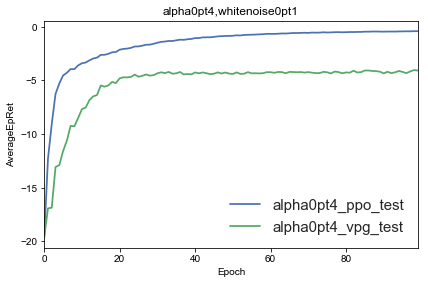

In [5]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)

# Use the commented section below if you're just plotting:

# seed = 1
# sigma = 0.5
# num_steps_per_epoch=5000
# num_epochs = 100 #(this will take like 5-10min per experiment, longer when it performs poorly)

# if seed==None:
#     seed_str = 'unseeded'
# else:
#     seed_str = 'seed{0}'.format(seed)

# if sigma==0:
#     noise_str = 'nonoise'
# else:
#     noise_str = 'whitenoise{0:.1f}'.format(sigma).replace('.','pt')

# # Setup outputs
# out_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
# fig_dir = out_dir+'/figures'
# exp_out_dir = '{0}/finhoriz_tests/{1}/{2}/'.format(out_dir,noise_str,seed_str).replace('.','pt')
# exp_fig_dir = '{0}/finhoriz_tests/{1}/{2}/'.format(fig_dir,noise_str,seed_str).replace('.','pt')

alphas = [0.4] #[2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
for alpha in alphas:#np.arange(0.0, 1.01, 0.1):#
    test_name = 'alpha{0:.1f}'.format(alpha).replace('.','pt')
#     print(exp_out_dir+test_name)
    data = plot.get_all_datasets([exp_out_dir+test_name], None, None, None)
    plt.figure()
    plt.title('{0},{1}'.format(test_name,noise_str))
    plot.plot_data(data)
#     plt.ylim((-4000, 0)) #bottom, top
    plt.savefig(exp_fig_dir+test_name)